# Sweet Lift Taxi Order Prediction

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a prediction model. The RMSE on the test set should not be more than 48. 

# Table of Contents
* [1. Data Preparation](#project_description)
* [2. EDA](#eda)
    * [2.1 Treating Outliers](#treating_outliers) 
    * [2.2 Creating New Features](#creating_new_features)
    * [2.3. Changing DTypes in df_hourly](#changing_dtypes_in_df_hourly)
    * [2.4. Plotting Hourly Orders](#plotting_hourly_orders)
    * [2.5 Distribution of Taxi Orders](#distribution_of_taxi_orders)
    * [2.6 Heatmap of Hourly Orders and Weekly Orders](#heatmap_of_hourly_orders)
    * [2.7 Hourly and Daily Trends](#hourly_and_daily_trends)
    * [2.8 Decomposing the Timeseries](#decomposing)
* [3. Model Training](#model_training)
    * [3.1 Building the Model](#Building_Model)
        * [3.1.1 Decision Tree](#Decision_Tree)
        * [3.1.2 Linear Regression](#Linear_Regression)
        * [3.1.3 Random Forest](#Random_Forest)
        * [3.1.4 Catboost Regressor](#xgb_regressor)
        * [3.1.5 XGB Regressor](#xgb_regressor)
    * [3,2. Summary of Models](#summary_models)
    * [3.3. Feature Imporatances of Best Model](#feature_importance)
* [4. Conclusions](#feature_importances)
* [5. Checklist](#conclusions)

# Data preparation

In [1]:
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn import tree

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.metrics import make_scorer, accuracy_score, recall_score, f1_score, roc_auc_score

import xgboost as XGBoostRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    df = pd.read_csv('taxi.csv', parse_dates = ['datetime'])

except:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates = ['datetime'])

df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col=['datetime'])

In [3]:
df.shape

(26496, 2)

In [4]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
#Finding missing values and high cardinality
def missing_values (data):
    df = pd.DataFrame ()
    for col in list(data):
        unique_values = data[col].unique()
        try:
            unique_values = np.sort(unique_values)
        except:
            pass
        nans = round(pd.isna(data[col]).sum()/data.shape[0]*100, 1)
        zeros = round((data[col] == 0).sum()/data.shape[0]*100, 1)
        
        df = df.append(pd.DataFrame([col, len(unique_values), nans, zeros]).T, ignore_index=True)
        
    return df.rename(columns = {0: 'variable',
1: 'Unique Values',
2: 'Nan %',
3: 'Zeros %',
4: 'empty'}).sort_values('Nan %', ascending=False)

missing_values(df)

,variable,Unique Values,Nan %,Zeros %
0,datetime,26496,0.0,0.0
1,num_orders,81,0.0,2.0


* Observations:
* No null values. 
* Datetime has over 26000 unique values. 

In [6]:
df.isnull().sum()

datetime      0
num_orders    0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [10]:
print(f"The duration of the dataset is from {df['datetime'].min()} to {df['datetime'].max()}")

The duration of the dataset is from 2018-03-01 00:00:00 to 2018-08-31 23:50:00


<AxesSubplot:>

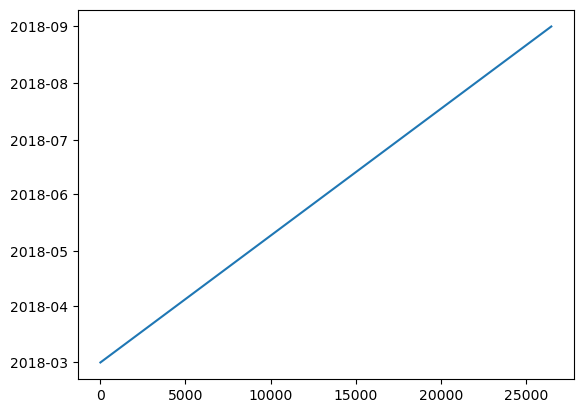

In [11]:
df['datetime'].plot()

<AxesSubplot:>

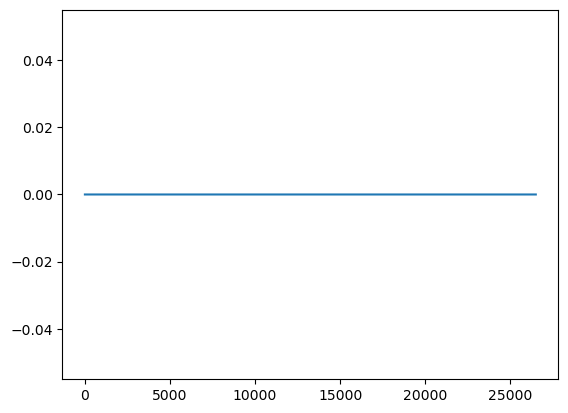

In [12]:
(df['datetime'] - df['datetime']).plot()

<AxesSubplot:xlabel='num_orders'>

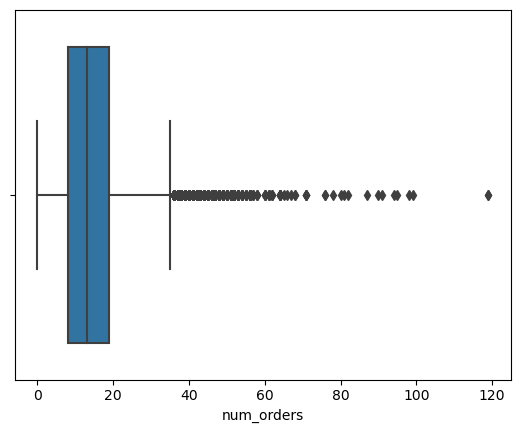

In [13]:
sns.boxplot(x=df['num_orders'])

* Observation:
* Number of taxi orders has a linear relationship to datetime. 
* There are no gaps between number of orders and datetime. 
* Based on the boxplot, the mean number of orders is 14 while there are obvious outliers. 

# EDA

## Treating Outliers

In [14]:
#investigating the outliers
def identify_outliers(column, df):
    Q1 = df[column].quantile(.25)
    Q3 = df[column].quantile(.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    df_outliers = df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]
    return df_outliers

for col in ['num_orders']:
    df = identify_outliers(col, df)

In [15]:
df.describe()

,num_orders
count,25809.000000
mean,13.278507
std,7.763121
min,0.000000
25%,7.000000
50%,12.000000
75%,18.000000
max,35.000000


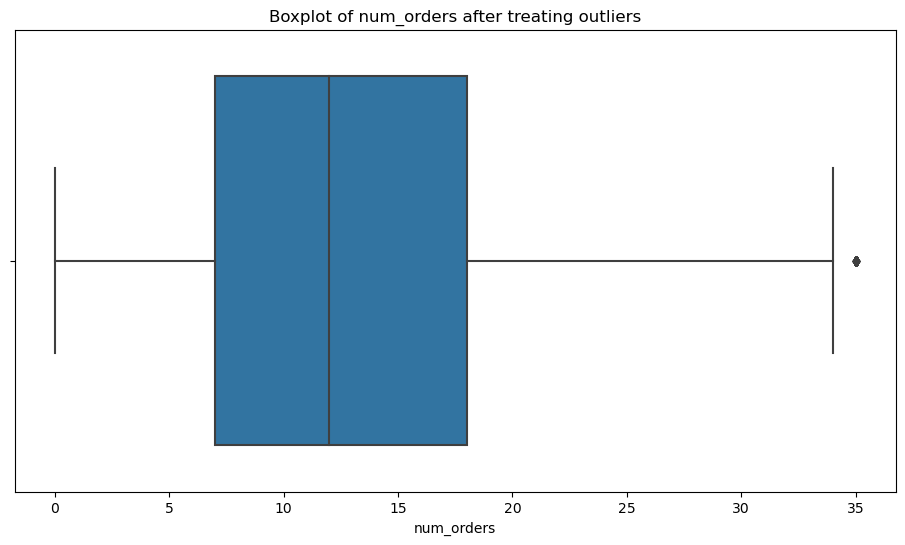

In [16]:
#Treating Outliers for Num_orders
plt.figure(figsize=(25, 6))

plt.subplot(1,2,1)
plt.title('Boxplot of num_orders after treating outliers')
sns.boxplot(data=df, x='num_orders')

plt.show()

## Creating New Features

In [17]:
df_hourly = df.copy(deep=True)
df_hourly.set_index('datetime', inplace=True)
df_hourly = df_hourly.resample('1H').sum()

In [18]:
def create_ts_features(df, dt_field, target, max_lag=1, rolling_window=1):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag+1):
        df['lag_{}'.format(str(lag))] = df[target].shift(lag)

    df['rolling_mean'] = df[target].shift().rolling(rolling_window).mean()
    df['rolling_median'] = df[target].shift().rolling(rolling_window).median()
    df['rolling_std'] = df[target].shift().rolling(rolling_window).std()

In [19]:
create_ts_features(df_hourly, 'datetime', 'num_orders', max_lag=7, rolling_window=7)

In [20]:
df_hourly.head(5)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_median,rolling_std
datetime,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN


## Changing DTypes in df_hourly

In [21]:
df_hourly.describe()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_median,rolling_std
count,4416.000000,4416.000000,4416.000000,4416.000000,4416.00000,4415.000000,4414.000000,4413.000000,4412.000000,4411.000000,4410.000000,4409.000000,4409.000000,4409.000000,4409.000000
mean,77.605299,5.505435,15.836957,3.005435,11.50000,77.597282,77.584504,77.566055,77.548731,77.535479,77.532200,77.527784,77.552312,77.386255,26.740306
std,34.281663,1.713306,8.855229,1.990684,6.92297,34.281406,34.274772,34.256730,34.241274,34.233840,34.237029,34.239657,22.125318,23.709731,9.085403
min,0.000000,3.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,17.000000,5.814596
25%,53.000000,4.000000,8.000000,1.000000,5.75000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,61.571429,60.000000,20.124612
50%,77.000000,5.500000,16.000000,3.000000,11.50000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,76.857143,77.000000,25.754334
75%,102.000000,7.000000,23.250000,5.000000,17.25000,102.000000,102.000000,102.000000,101.250000,101.000000,101.000000,101.000000,94.428571,95.000000,32.277074
max,177.000000,8.000000,31.000000,6.000000,23.00000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,135.714286,152.000000,59.026628


In [22]:
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num_orders      4416 non-null   int64  
 1   month           4416 non-null   int64  
 2   day             4416 non-null   int64  
 3   dayofweek       4416 non-null   int64  
 4   hour            4416 non-null   int64  
 5   lag_1           4415 non-null   float64
 6   lag_2           4414 non-null   float64
 7   lag_3           4413 non-null   float64
 8   lag_4           4412 non-null   float64
 9   lag_5           4411 non-null   float64
 10  lag_6           4410 non-null   float64
 11  lag_7           4409 non-null   float64
 12  rolling_mean    4409 non-null   float64
 13  rolling_median  4409 non-null   float64
 14  rolling_std     4409 non-null   float64
dtypes: float64(10), int64(5)
memory usage: 552.0 KB


In [23]:
cols_to_num = [
    'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'rolling_median'
]
df_hourly[cols_to_num] = df_hourly[cols_to_num].astype('Int16')

In [24]:
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num_orders      4416 non-null   int64  
 1   month           4416 non-null   int64  
 2   day             4416 non-null   int64  
 3   dayofweek       4416 non-null   int64  
 4   hour            4416 non-null   int64  
 5   lag_1           4415 non-null   Int16  
 6   lag_2           4414 non-null   Int16  
 7   lag_3           4413 non-null   Int16  
 8   lag_4           4412 non-null   Int16  
 9   lag_5           4411 non-null   Int16  
 10  lag_6           4410 non-null   Int16  
 11  lag_7           4409 non-null   Int16  
 12  rolling_mean    4409 non-null   float64
 13  rolling_median  4409 non-null   Int16  
 14  rolling_std     4409 non-null   float64
dtypes: Int16(8), float64(2), int64(5)
memory usage: 379.5 KB


## Plotting Hourly Orders

In [25]:
def plot_orders(dfs, field, r=1, c=1, figsize=(12, 10), is_mean_window=False,
                window=1, titles=[], sup_title=None):
    fig, axes = plt.subplots(r, c, figsize=figsize)
    if not is_mean_window:
        for idx, (df, title, ax) in enumerate(zip(dfs, titles, axes.flatten())):
            sns.lineplot(df, ax=ax)
            axes[idx].set_title(title)
    else:
        for idx, (df, title, ax) in enumerate(zip(dfs, titles, axes.flatten())):
            sns.lineplot(df, ax=ax, label='hourly trend')
            sns.lineplot(df.shift().rolling(window).mean(), ax=ax, label='mean')
            sns.lineplot(df.shift().rolling(window).std(), ax=ax, label='std')
            axes[idx].set_title(title)
    axes.flat[-1].set_visible(False) 
    plt.suptitle(sup_title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [26]:
hourly_orders = df.set_index('datetime')['num_orders'].resample('1H').mean()
daily_orders = df.set_index('datetime')['num_orders'].resample('1D').mean()
monthly_orders = df.set_index('datetime')['num_orders'].resample('1M').mean()

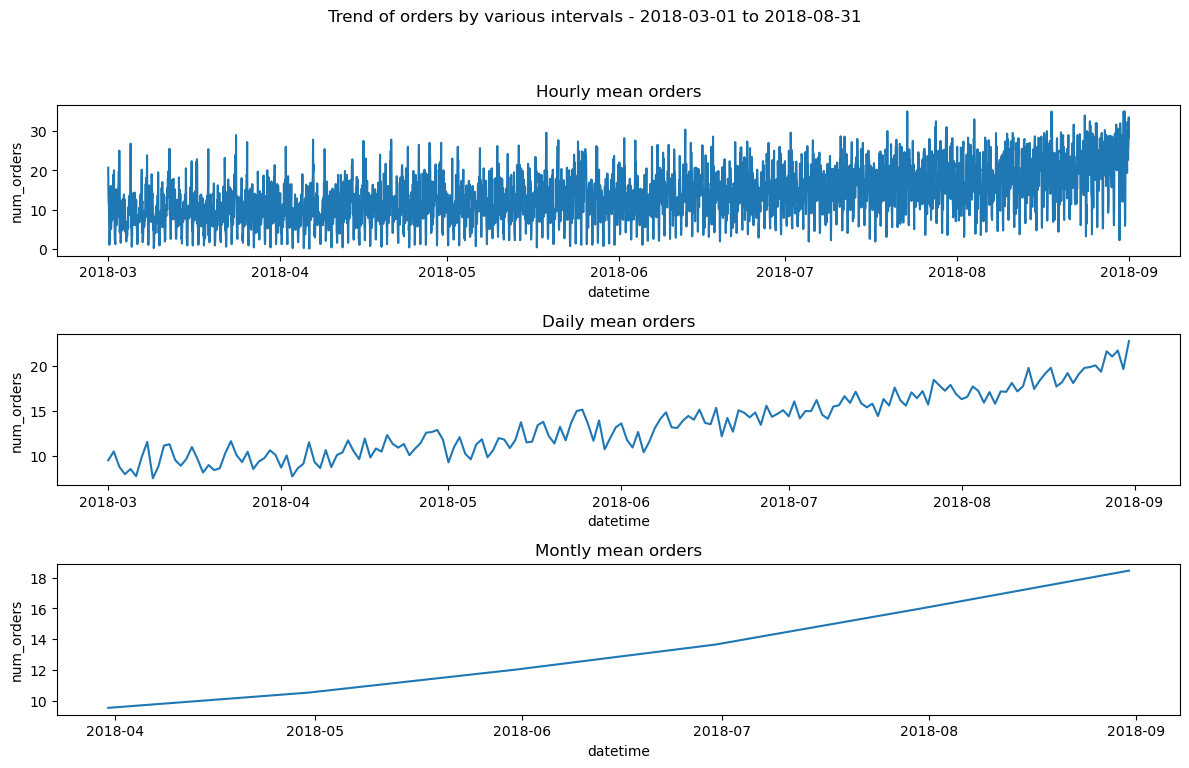

In [27]:
orders = [hourly_orders, daily_orders, monthly_orders]
titles = ['Hourly mean orders',
         'Daily mean orders',
         'Montly mean orders'
         ]
sup_title = 'Trend of orders by various intervals - 2018-03-01 to 2018-08-31'
plot_orders(orders, 'num_orders', r=4, c=1, titles=titles, sup_title=sup_title)

* Observation:
* The overall trend is upward of the mean orders from March 2018 to August 2018. 

## Distribution of Taxi Orders

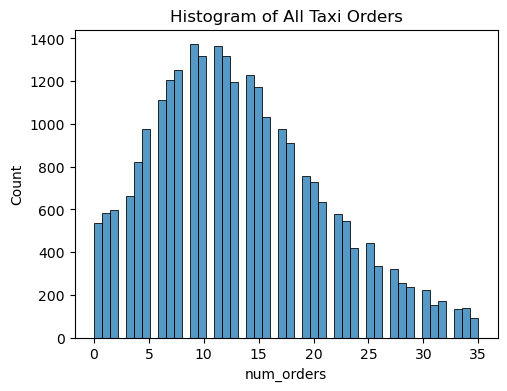

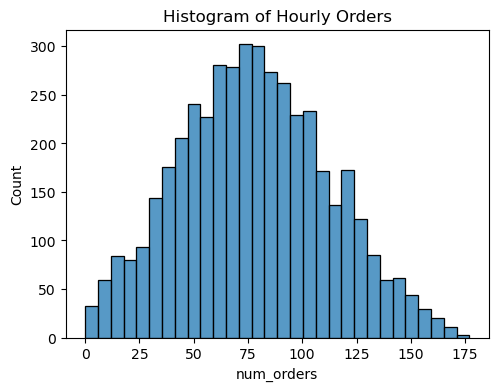

In [28]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=df, x="num_orders")
plt.title('Histogram of All Taxi Orders')
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,2,2)
sns.histplot(data=df_hourly, x="num_orders")
plt.title('Histogram of Hourly Orders')
plt.show()

* Observation
* The histogram for all orders shows right-skewed distribution. The mean is higher than the median.
* The histogram for hourly orders shows symmetric distribution (unimodel). 

## Heatmap of Hourly Orders and Weekly Orders

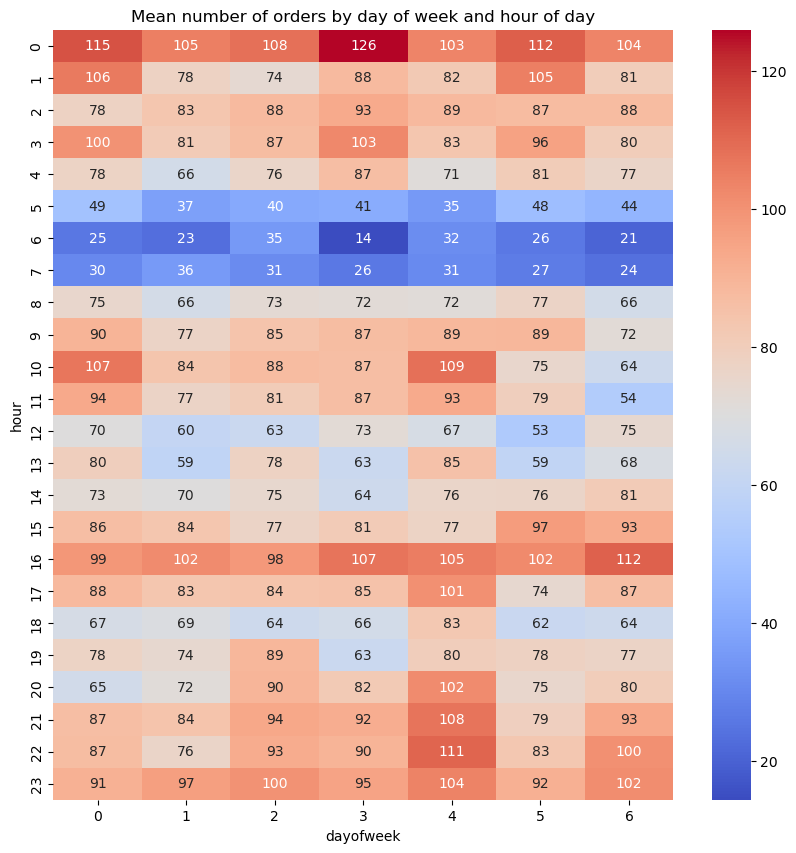

In [29]:
pivoted_df = df_hourly.pivot_table(index=['hour'], columns=['dayofweek'], values=['num_orders'], aggfunc='mean')
pivoted_df = pivoted_df.droplevel(0, axis=1)
plt.figure(figsize=(10, 10))
sns.heatmap(pivoted_df, annot=True, cmap="coolwarm", fmt=".0f")
plt.title('Mean number of orders by day of week and hour of day')
plt.show()

* Observations:
* 12 AM has the highest number of orders than any other time of the day. 12 AM Sunday to be exact have the highest mean number of order of 169. 
* Between 5 AM and 7 AM, orders drop and continuous to do so during the week. 
* Between 8 PM to 3 AM the next day has the highest number of cumulutative orders during the week.   

## Hourly and Daily Trends

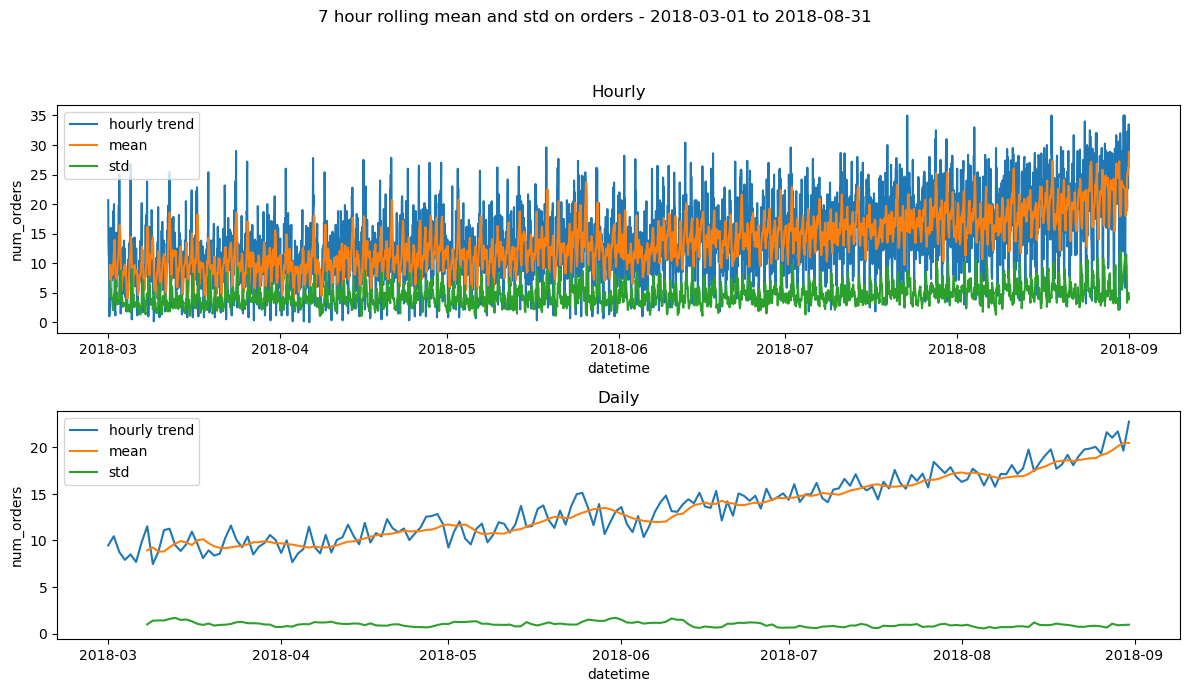

In [30]:
resample_df_list = [hourly_orders, daily_orders]
titles = [
         'Hourly',
         'Daily'
         ]
window = 7
sup_title = f'{window} hour rolling mean and std on orders - 2018-03-01 to 2018-08-31'
plot_orders(resample_df_list, 'num_orders', r=3, c=1, is_mean_window=True, window=window, 
            titles=titles, sup_title=sup_title)

* Observation:
* The daily mean orders are smoother than hourly mean orders. 

## Decomposing the Timeseries

In [31]:
df_hourly = df_hourly.dropna()

In [32]:
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4409 entries, 2018-03-01 07:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num_orders      4409 non-null   int64  
 1   month           4409 non-null   int64  
 2   day             4409 non-null   int64  
 3   dayofweek       4409 non-null   int64  
 4   hour            4409 non-null   int64  
 5   lag_1           4409 non-null   Int16  
 6   lag_2           4409 non-null   Int16  
 7   lag_3           4409 non-null   Int16  
 8   lag_4           4409 non-null   Int16  
 9   lag_5           4409 non-null   Int16  
 10  lag_6           4409 non-null   Int16  
 11  lag_7           4409 non-null   Int16  
 12  rolling_mean    4409 non-null   float64
 13  rolling_median  4409 non-null   Int16  
 14  rolling_std     4409 non-null   float64
dtypes: Int16(8), float64(2), int64(5)
memory usage: 378.9 KB


In [33]:
df_hourly.shape

(4409, 15)

In [34]:
result = seasonal_decompose(df_hourly['num_orders'])

<AxesSubplot:title={'center':'Seasonal Analysis of Mean Orders'}, xlabel='datetime'>

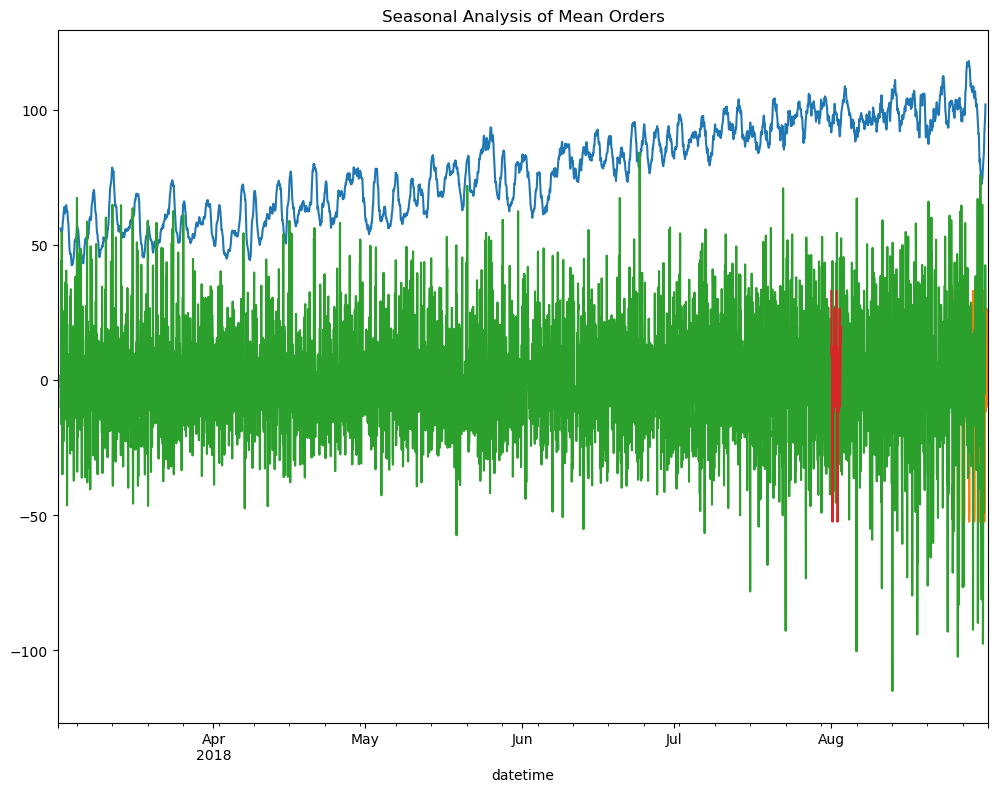

In [35]:
result.trend.plot(figsize=(12, 9), title='Trend analysis of hourly orders')
result.seasonal.tail(24*7).plot(figsize=(12, 9), title="Seasonal analysis of last 7 days' hourly orders")
result.resid.plot(figsize=(12, 9), title="Residual plot of hourly orders")
result.seasonal['2018-08-01': '2018-08-02'].plot(figsize=(12, 9), title="Seasonal Analysis of Mean Orders")

In [36]:
result1 = seasonal_decompose(df_hourly['rolling_mean'])

<AxesSubplot:title={'center':'Seasonal Analysis of Rolling Mean'}, xlabel='datetime'>

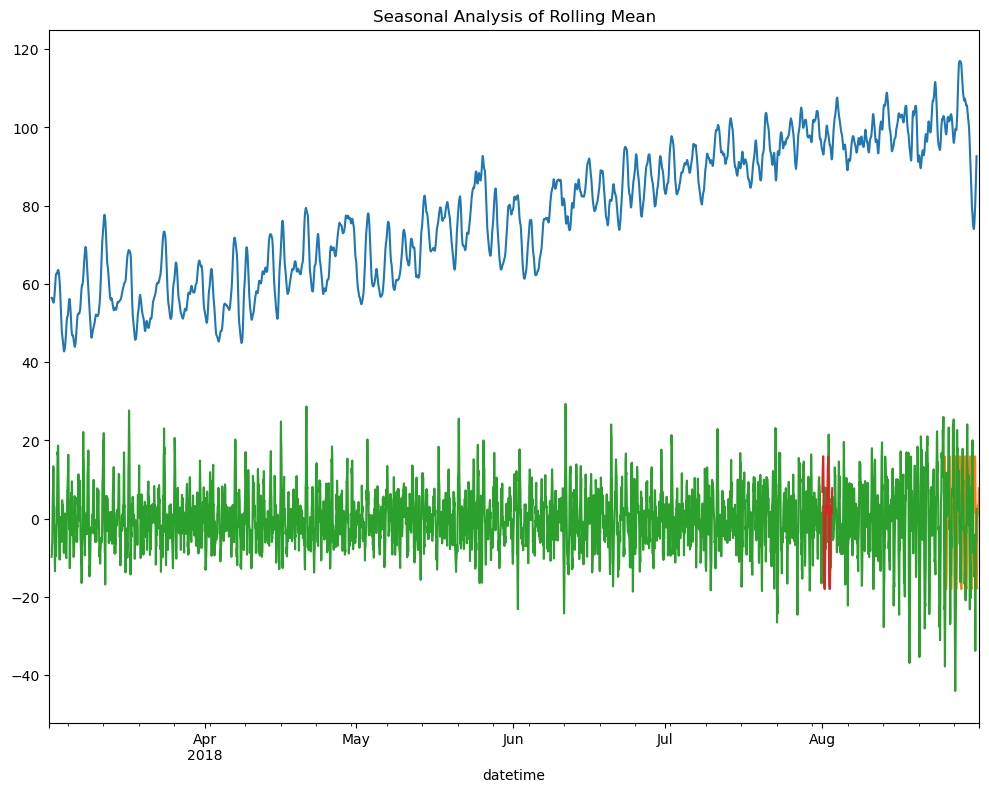

In [37]:
result1.trend.plot(figsize=(12, 9), title='Trend analysis of hourly orders')
result1.seasonal.tail(24*7).plot(figsize=(12, 9), title="Seasonal analysis of last 7 days' hourly orders")
result1.resid.plot(figsize=(12, 9), title="Residual plot of hourly orders")
result1.seasonal['2018-08-01': '2018-08-02'].plot(figsize=(12, 9), title="Seasonal Analysis of Rolling Mean")

In [38]:
result2 = seasonal_decompose(df_hourly['rolling_std'])

<AxesSubplot:title={'center':'Seasonal analysis of Rolling Std'}, xlabel='datetime'>

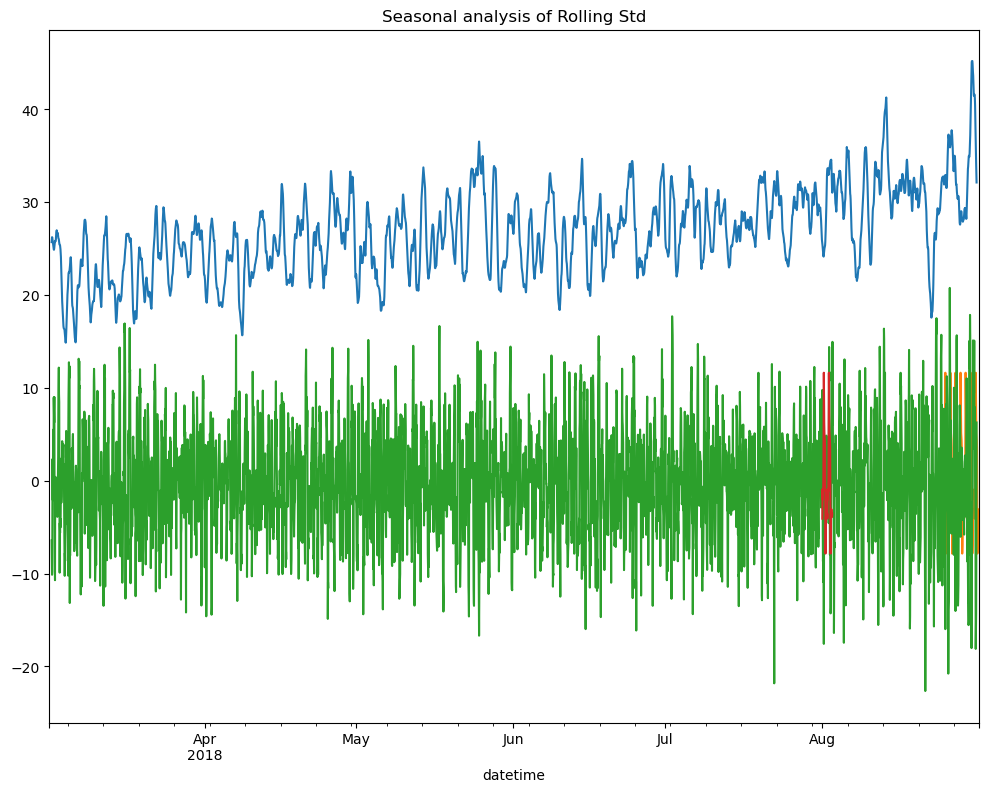

In [39]:
result2.trend.plot(figsize=(12, 9), title='Trend analysis of hourly orders')
result2.seasonal.tail(24*7).plot(figsize=(12, 9), title="Seasonal analysis of last 7 days' hourly orders")
result2.resid.plot(figsize=(12, 9), title="Residual plot of hourly orders")
result2.seasonal['2018-08-01': '2018-08-02'].plot(figsize=(12, 9), title="Seasonal analysis of Rolling Std")

* Observation:
* The trend plot shows an upward trend. 
* The seasonal trend shows there is a seasonal pattern.
* THe residuals show a residual mean is not 0. The spikes in August indicates that Sweet Lift Taxi company peaks with orders. More orders means more peaks. 
* The seasonal analysis for one day shows orders are more frequent at midnight, slows down to 6 AM increases around 6 or 7 PM. 

# Model training

In [40]:
#Splitting the Data
X = df_hourly.drop(['num_orders'], axis=1)
y = df_hourly['num_orders']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
valid_X, test_X, valid_y, test_y = train_test_split(test_X, test_y, test_size=0.1, random_state=42)

In [41]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape, valid_X.shape, valid_y.shape

((3527, 14), (89, 14), (3527,), (89,), (793, 14), (793,))

## Building the Model

In [42]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [43]:
def build_model(model, train_X, train_y, test_X, test_y, 
                hyperparameters={}, 
                scoring=None, cv=5, model_str=None, cat_features=[], verbose=False):
    np.random.seed(42)
    best_rmse = 0
    start_time = time.time()
    
    gs = GridSearchCV(model, param_grid=hyperparameters, cv=cv, scoring=scoring)
    gs.fit(train_X, train_y)
    if model_str == 'catboost':
        gs.best_estimator_.fit(train_X, train_y, cat_features=cat_features, verbose=verbose)
    else:
        gs.best_estimator_.fit(train_X, train_y)
    preds = gs.best_estimator_.predict(test_X)
    best_rmse = rmse(test_y, preds)
    end_time = time.time() - start_time
    return gs.best_estimator_, best_rmse, np.round(end_time, 2)

In [44]:
X = df_hourly.drop(['num_orders'], axis=1)
y = df_hourly['num_orders']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=42)
valid_X, test_X, valid_y, test_y = train_test_split(test_X, test_y, test_size=0.1, random_state=42)

In [45]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((3968, 14), (3968,), (45, 14), (45,))

In [46]:
timecv = TimeSeriesSplit(n_splits=5)

In [47]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [48]:
def build_model (model, train_X, train_y, valid_X, valid_y,
                 hyperparameters={},
                 scoring=None, cv=5, model_str=None, cat_features=[], verbose=False):
    
    np.random.seed(42)
    best_rmse=0
    start_time = time.time()
    
    gs = GridSearchCV(model, param_grid=hyperparameters, cv=cv, scoring=scoring)
    gs.fit(train_X, train_y)
    if model_str == 'catboost':
        gs.best_estimator_.fit(train_X, train_y, cat_features = cat_features, verbose=verbose)
    else:
        gs.best_estimator_.fit(train_X, train_y)
    preds = gs.best_estimator_.predict(valid_X)
    best_rmse = rmse(valid_y, preds)
    end_time = time.time() - start_time
    return gs.best_estimator_, best_rmse, np.round(end_time, 2)

### Decision Tree

In [49]:
dtf = tree.DecisionTreeClassifier(max_depth=3)
best_dtf_model, best_dtf_rmse, best_dtf_time = build_model(
    dtf, train_X, train_y, valid_X, valid_y, hyperparameters={},
    scoring=make_scorer(rmse), cv=5, model_str='dtf')

In [50]:
%%time
dtf.fit(train_X, train_y)
y_pred = dtf.predict(test_X)
dtf_rmse = mean_squared_error(test_y, y_pred)
print(f"RMSE Score (Decision Tree): {dtf_rmse:.2f}")

RMSE Score (Decision Tree): 1057.82
CPU times: user 24.8 ms, sys: 54 µs, total: 24.8 ms
Wall time: 23.9 ms


### Linear Regression

In [51]:
lr_model = LinearRegression()
best_lr_model, best_lr_rmse, best_lr_time = build_model(
    lr_model, train_X, train_y, valid_X, valid_y, hyperparameters={},
    scoring=make_scorer(rmse), cv=5, model_str='lr')

In [52]:
%%time
lr_model.fit(train_X, train_y)
y_pred = lr_model.predict(test_X)
lr_rmse = mean_squared_error(test_y, y_pred)
print(f"RMSE Score (Linear Regression) {lr_rmse:.2f}")

RMSE Score (Linear Regression) 757.10
CPU times: user 37.5 ms, sys: 0 ns, total: 37.5 ms
Wall time: 9.3 ms


### Random Forest

In [53]:
rf = RandomForestRegressor(n_estimators=50, max_depth=15, n_jobs=-1, random_state=1234)
best_rf_model, best_rf_rmse, best_rf_time = build_model(rf, train_X, train_y,
                                                        valid_X, valid_y,
                                                        hyperparameters={},
                                                        scoring=make_scorer(rmse), cv=5, model_str='rf')

In [54]:
%%time
rf.fit(train_X, train_y)
y_pred = rf.predict(test_X)
rf_rmse = mean_squared_error(test_y,y_pred)
print(f"RMSE Score (Random Forest): {rf_rmse:.2f}")

RMSE Score (Random Forest): 648.21
CPU times: user 1.7 s, sys: 27 ms, total: 1.73 s
Wall time: 316 ms


### CatBoost Regressor

In [55]:
cat_features = []
cat_model = CatBoostRegressor(learning_rate=0.9, loss_function='RMSE', random_seed=42)
best_cat_model, best_cat_rmse, best_cat_time = build_model(cat_model, train_X, train_y,
                                                        valid_X, valid_y,
                                                        hyperparameters={'iterations': [20, 30, 40, 50]},
                                                        scoring=make_scorer(rmse), cv=5, model_str='catboost', cat_features=cat_features)

0:	learn: 25.2087104	total: 73.7ms	remaining: 1.4s
1:	learn: 23.9478245	total: 78.8ms	remaining: 709ms
2:	learn: 23.0969757	total: 81.7ms	remaining: 463ms
3:	learn: 22.4918471	total: 84.4ms	remaining: 338ms
4:	learn: 21.8867855	total: 87.1ms	remaining: 261ms
5:	learn: 21.4093798	total: 89.4ms	remaining: 209ms
6:	learn: 21.2185877	total: 91.7ms	remaining: 170ms
7:	learn: 21.0162418	total: 94.1ms	remaining: 141ms
8:	learn: 20.6283140	total: 95.8ms	remaining: 117ms
9:	learn: 20.2015600	total: 97.3ms	remaining: 97.3ms
10:	learn: 20.0348552	total: 99.2ms	remaining: 81.1ms
11:	learn: 19.6179283	total: 101ms	remaining: 67.3ms
12:	learn: 19.5695274	total: 103ms	remaining: 55.4ms
13:	learn: 19.3447829	total: 105ms	remaining: 44.8ms
14:	learn: 19.1202031	total: 106ms	remaining: 35.5ms
15:	learn: 19.0973530	total: 108ms	remaining: 27ms
16:	learn: 18.8951007	total: 110ms	remaining: 19.4ms
17:	learn: 18.5397211	total: 112ms	remaining: 12.4ms
18:	learn: 18.2492723	total: 114ms	remaining: 5.99ms
19:	

In [56]:
%%time
cat_model.fit(train_X, train_y, verbose=False)
y_pred = cat_model.predict(test_X)
cat_rmse = mean_squared_error(test_y, y_pred, squared=False)
print(f"RMSE Score (CatBoost): {cat_rmse:.2f}")

RMSE Score (CatBoost): 23.19
CPU times: user 8.45 s, sys: 1.5 s, total: 9.95 s
Wall time: 2.01 s


### XGB Regressor

In [57]:
xgb_model = XGBoostRegressor.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.1, max_depth=6)
best_xgb_model, best_xgb_rmse, best_xgb_time = build_model(xgb_model, train_X, train_y,
                                                        valid_X, valid_y,
                                                        hyperparameters={},
                                                        scoring=make_scorer(rmse), cv=5, model_str='xgb')

In [58]:
%%time
xgb_model.fit(train_X, train_y, early_stopping_rounds=10, eval_metric="rmse", eval_set=[(test_X, test_y)], verbose=False)
y_pred = xgb_model.predict(test_X)
xgb_rmse = mean_squared_error(test_y, y_pred, squared=False)
print(f"RMSE Score (XGB): {xgb_rmse:.2f}")

RMSE Score (XGB): 24.06
CPU times: user 2.97 s, sys: 169 ms, total: 3.14 s
Wall time: 439 ms


## Summary of Models

In [59]:
df_models = pd.DataFrame({'model': ['DTree', 'LRegression', 'RForest', 'CatBoost', 'XGB'],
                         'RMSE': [best_dtf_rmse, best_lr_rmse, best_rf_rmse, best_cat_rmse, best_xgb_rmse],
                         'Train_Time': [best_dtf_time, best_lr_time, best_rf_time, best_cat_time, best_xgb_time]})

In [60]:
df_models

,model,RMSE,Train_Time
0,DTree,27.654159,0.40
1,LRegression,27.194960,0.87
2,RForest,21.797310,3.35
3,CatBoost,22.992923,11.38
4,XGB,21.942913,15.90


* Observations:
* The best performing model is **Random Forest with the lowest mean order of 21.7** with 3 seconds. 

## Feature Importances of Best Model

In [61]:
feature_imp = pd.DataFrame(best_rf_model.feature_importances_, index=df_hourly.columns[1:].tolist()).sort_values(0, ascending=False).reset_index()
feature_imp.rename(columns={'index':'Features', 0:'Value'}, inplace=True)

In [62]:
feature_imp

,Features,Value
0,lag_1,0.256734
1,hour,0.226353
2,rolling_mean,0.086626
3,month,0.073229
4,lag_7,0.056544
5,lag_6,0.042695
6,lag_5,0.040898
7,lag_3,0.037201
8,lag_4,0.035379
9,lag_2,0.035185


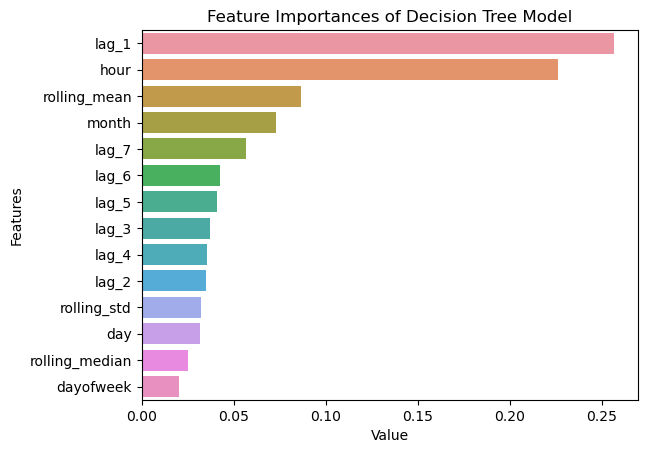

In [63]:
plt.title('Feature Importances of Decision Tree Model') 
sns.barplot(
    data=feature_imp.sort_values('Value', ascending=False),
    y='Features',
    x='Value',
    orient='h',
)

plt.show()

* Observations:
* The top 3 important features are: **lag_1, hour, and rolling mean.** 

## Model Analysis

In [64]:
def test_pred(model, test_X, test_y):
    start_time = time.time()
    preds = model.predict(test_X)
    return np.round(time.time(), 2) - start_time, rmse(test_y, preds)

In [65]:
models = [best_dtf_model, best_lr_model, best_rf_model, best_cat_model, best_xgb_model]
for model in models:
    pred_time, best_rmse = test_pred(model, test_X, test_y)
    print(f"The RMSE on the test set is: {best_rmse}, and time to predict {pred_time} seconds.")

The RMSE on the test set is: 32.524179039942304, and time to predict -0.001912832260131836 seconds.
The RMSE on the test set is: 27.515466694286904, and time to predict 0.004746437072753906 seconds.
The RMSE on the test set is: 25.459971741811646, and time to predict 0.01951432228088379 seconds.
The RMSE on the test set is: 22.449994604001585, and time to predict 0.0036559104919433594 seconds.
The RMSE on the test set is: 24.183994232588958, and time to predict 0.011872291564941406 seconds.


* Observations:
* When using the prediction time, Linear Regression is the fastest with 0.002 seconds. 
* CatBoost has the least RMSE of 22.44 but have negative seconds.  

In [66]:
test_set = test_X.merge(df_hourly['num_orders'], left_index=True, right_index=True)['num_orders']
final_result = pd.DataFrame(test_set, columns=['num_orders'])

<AxesSubplot:xlabel='datetime'>

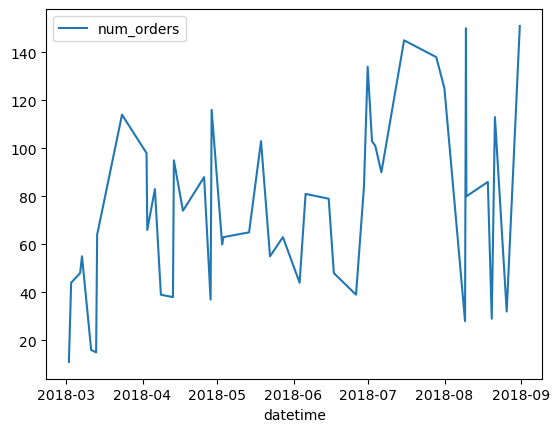

In [67]:
sns.lineplot(data=final_result)

# Conclusions

This project aims to compare ML models in order to select an optimal model to determine the number of taxi orders for Sweet Lift Taxi company. Originally, the data has 26496 rows and 2 columns: datetime and num_orders. 

At the EDA processing, duplicates were dropped and outliers are treated using the IQR method. There are no missing values. There are also no gaps in the datetime and number of orders. It was determined that the mean number of orders is 14 and ranges from 0 - 119. 

In preparing for the modelling, the dataset was processed further into hourly intervals. 7 lags, rolling_mean, rolling_median, and rolling_std were processed in the dataset as well. 10% was used for testing. The following were used as models along with hyperparameter tuning: Decision Tree, Linear Regression, Random Forest, Catboost Regressor, and XGB Regressor. In plotting for time series into hourly, daily, and monthly, it was observed that there is an upward trend between March 1, 2018 and August 31, 2018. The histogram of all orders shows right-skewed data while histogram of hourly orders shows a symmetric distribution. When determining the mean number of orders by weekdays and hours using the heatmap, most orders are highest at 12 AM on Sunday. The numbers dropped from 5 AM to 7 AM and picks up again, 6 PM to 4 AM the next day in any day of the week. When the rollling mean and rolling std was processed, the daily data is smoother than hourly data. When seasonal_decompose function was used, the trend is stil showing upward trend. The residuals shows the mean is not 0 indicating no bias in the predictions. The spikes in the month of August shows peaks with how frequent the orders are.  

In modelling the dataset, the RMSE, training time, and prediction time are determined. The best performing model is Random Forest with the lowest mean order of 21.7 with 3 seconds. The RMSE scores at training time are not far off from each other but the training time are. 

After analyzing the models, Linear Regression is the fastest with 0.002 seconds. CatBoost has the least RMSE of 22.44 but have negative seconds. ThE RMSE on the test set are below 40. 